In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

from tensorflow import keras
from tensorflow.keras import layers


In [2]:
df=pd.read_csv('train.csv')
print(df.shape)

df.head(2)

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0


(array([1225312.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   80810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

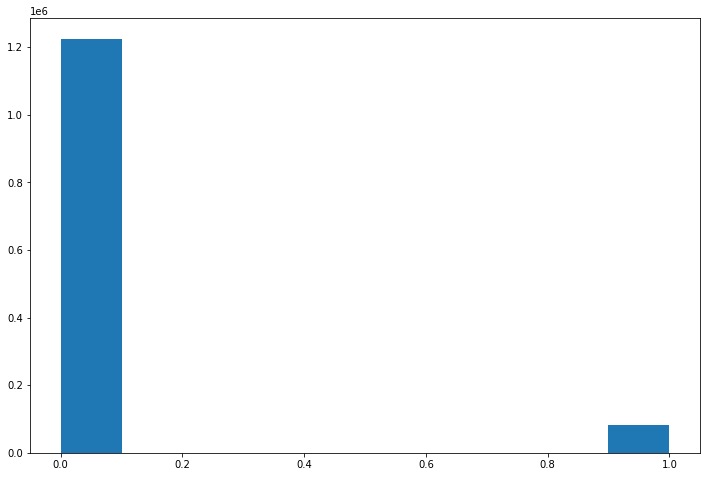

In [3]:
plt.hist(x=df['target'])

In [4]:
df[df['target']==1].head(1).values

array([['0000e91571b60c2fb487',
        'Has the United States become the largest dictatorship in the world?',
        1]], dtype=object)

In [5]:
from sklearn.model_selection import train_test_split

df_train,remaining = train_test_split(df, train_size=0.01, random_state=42)
df_validation,_ = train_test_split(remaining, train_size=0.001, random_state=42)
df_train.shape,df_validation.shape

((13061, 3), (1293, 3))

considering a trained model from tensorflow hub for embed the text data :
"https://tfhub.dev/google/nnlm-en-dim128/2" which produces the output of vector array of length 128

In [6]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = embed(["cat is on the mat"])

In [7]:
embeddings

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.27107972, -0.01055073, -0.05728397,  0.06853679, -0.08438271,
         0.22396211, -0.00247001, -0.09797598, -0.06092518,  0.01678422,
         0.0183306 , -0.02683547,  0.01987647,  0.02205245,  0.0380337 ,
         0.02345292, -0.0535214 , -0.02916854, -0.13816142,  0.255649  ,
         0.00548296,  0.08994407,  0.09702856, -0.01617393,  0.15273312,
         0.03449007,  0.05599031,  0.01964826, -0.01901525,  0.11601479,
         0.06575833, -0.03560898, -0.02412845, -0.00716866, -0.08950593,
        -0.01021391,  0.07431487, -0.10462939, -0.03951982,  0.00272066,
        -0.01468687, -0.01350653, -0.04825642,  0.03088917, -0.0448269 ,
        -0.01743765,  0.1034883 ,  0.04149228, -0.03979184,  0.03878277,
         0.15273733, -0.09228262, -0.01723959,  0.01830614, -0.02075483,
         0.0800882 , -0.08071491, -0.15573218,  0.13893387,  0.06140287,
        -0.05639812, -0.05526257, -0.02765993, -0.175832  ,  0.01034007,
 

In [8]:
hub_url='https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1'

In [9]:
hub_url_1='https://tfhub.dev/google/universal-sentence-encoder/4'

In [10]:
def model_evaluation(hub_url,embded_size,name,trainable=False):

    hub_layer = hub.KerasLayer(hub_url,
                               input_shape=[],output_shape=embded_size, dtype=tf.string,trainable=trainable)

    model = keras.Sequential()
    model.add(hub_layer)
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])
    model.summary()

    history=model.fit(df_train['question_text'],df_train['target'],
                      epochs=100,
                      batch_size=32,
                      validation_data=(df_validation['question_text'],df_validation['target']),
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)]
                 )
    return history


In [11]:
histories={}

In [12]:
histories['nnlm-en-dim128']=model_evaluation(hub_url,128,'nnlm-en-dim128')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 124,692,225
Trainable params: 49,537
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/100
409/409 [==============================] - 16s 12ms/step - loss: 0.1851 - accuracy: 0.9401 - val_loss: 0.1374 - val_accuracy: 0.9520
Epoch 2/100
409/409 [==============================] - 3s 7ms/step - loss: 0.1466 - accura

In [13]:
histories['universal-sentence-encoder']=model_evaluation(hub_url_1,512,'universal-sentence-encoder')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________
Epoch 1/100
409/409 [==============================] - 25s 22ms/step - loss: 0.1582 - accuracy: 0.9419 - val_loss: 0.1119 - val_accuracy: 0.9536
Epoch 2/100
409/409 [==============================] - 10s 23ms/step - loss: 0.1126 - a

In [14]:
histories['universal-sentence-encoder'].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

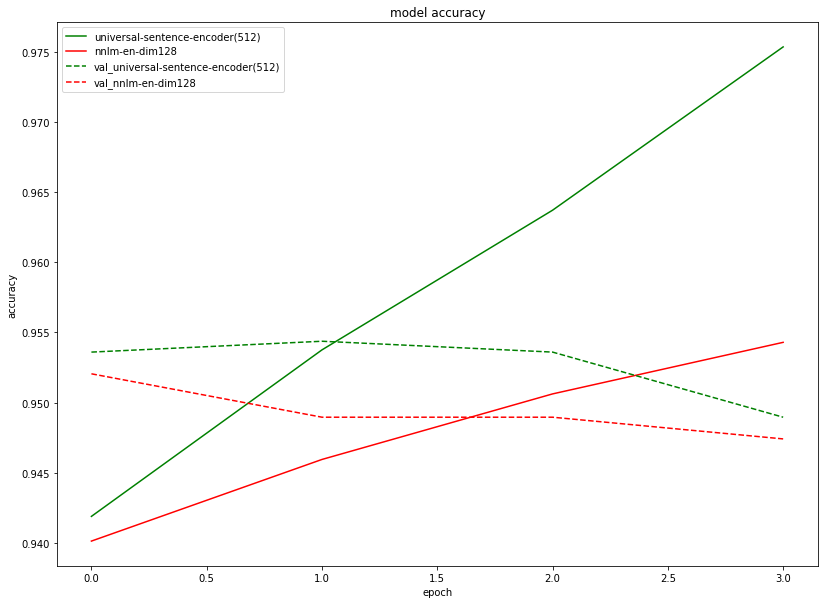

In [33]:
plt.subplots(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.plot(histories['universal-sentence-encoder'].history['accuracy'],color='green')
plt.plot(histories['nnlm-en-dim128'].history['accuracy'],color='red')
plt.plot(histories['universal-sentence-encoder'].history['val_accuracy'],color='green',linestyle='dashed')
plt.plot(histories['nnlm-en-dim128'].history['val_accuracy'],color='red',linestyle='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['universal-sentence-encoder(512)', 'nnlm-en-dim128','val_universal-sentence-encoder(512)', 'val_nnlm-en-dim128'], loc='upper left')
plt.show()

# plt.subplot(1, 2, 2)
# plt.plot(histories['universal-sentence-encoder'].history['loss'])
# plt.plot(histories['nnlm-en-dim128'].history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['universal-sentence-encoder(512)', 'nnlm-en-dim128'])
# plt.show()


## __Fine Tuning :__

Training the 

In [ ]:
histories['fine-tuned_nnlm-en-dim128']=model_evaluation(hub_url,128,'nnlm-en-dim128',trainable=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 124,692,225
Trainable params: 124,692,225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
409/409 [==============================] - 1049s 2s/step - loss: 0.1803 - accuracy: 0.9417 - val_loss: 0.1367 - val_accuracy: 0.9505
Epoch 2/100
409/409 [==============================] - 840s 2s/step - loss: 0.0816 - accuracy